In [1]:
import math
import types

import numpy as np
import scipy as sp
import torch
import torch.nn as nn
import torch.nn.functional as F

import matplotlib.pyplot as plt
import copy
import torch.optim as optim
import torch.utils.data


In [3]:
# Alle Elemente die in pytorch-flows definiert werden https://github.com/ikostrikov/pytorch-flows

def get_mask(in_features, out_features, in_flow_features, mask_type=None):
    """
    mask_type: input | None | output
    
    See Figure 1 for a better illustration:
    https://arxiv.org/pdf/1502.03509.pdf
    """
    if mask_type == 'input':
        in_degrees = torch.arange(in_features) % in_flow_features
    else:
        in_degrees = torch.arange(in_features) % (in_flow_features - 1)

    if mask_type == 'output':
        out_degrees = torch.arange(out_features) % in_flow_features - 1
    else:
        out_degrees = torch.arange(out_features) % (in_flow_features - 1)

    return (out_degrees.unsqueeze(-1) >= in_degrees.unsqueeze(0)).float()


class MaskedLinear(nn.Module):
    def __init__(self,
                 in_features,
                 out_features,
                 mask,
                 cond_in_features=None,
                 bias=True):
        super(MaskedLinear, self).__init__()
        self.linear = nn.Linear(in_features, out_features)
        if cond_in_features is not None:
            self.cond_linear = nn.Linear(
                cond_in_features, out_features, bias=False)

        self.register_buffer('mask', mask)

    def forward(self, inputs, cond_inputs=None):
        output = F.linear(inputs, self.linear.weight * self.mask,
                          self.linear.bias)
        if cond_inputs is not None:
            output += self.cond_linear(cond_inputs)
        return output


nn.MaskedLinear = MaskedLinear


class MADE(nn.Module):
    """ An implementation of MADE
    (https://arxiv.org/abs/1502.03509s).
    """

    def __init__(self,
                 num_inputs,
                 num_hidden,
                 num_cond_inputs=None,
                 act='relu'):
        super(MADE, self).__init__()

        activations = {'relu': nn.ReLU, 'sigmoid': nn.Sigmoid, 'tanh': nn.Tanh}
        act_func = activations[act]

        input_mask = get_mask(
            num_inputs, num_hidden, num_inputs, mask_type='input')
        hidden_mask = get_mask(num_hidden, num_hidden, num_inputs)
        output_mask = get_mask(
            num_hidden, num_inputs * 2, num_inputs, mask_type='output')

        self.joiner = nn.MaskedLinear(num_inputs, num_hidden, input_mask,
                                      num_cond_inputs)

        self.trunk = nn.Sequential(act_func(),
                                   nn.MaskedLinear(num_hidden, num_hidden,
                                                   hidden_mask), act_func(),
                                   nn.MaskedLinear(num_hidden, num_inputs * 2,
                                                   output_mask))

    def forward(self, inputs, cond_inputs=None, mode='direct'):
        if mode == 'direct':
            h = self.joiner(inputs, cond_inputs)
            m, a = self.trunk(h).chunk(2, 1)    #mu and alpha in Eq (4) MAF
            u = (inputs - m) * torch.exp(-a)
            return u, -a.sum(-1, keepdim=True)  

        else:
            x = torch.zeros_like(inputs)
            for i_col in range(inputs.shape[1]):
                h = self.joiner(x, cond_inputs)
                m, a = self.trunk(h).chunk(2, 1)
                x[:, i_col] = inputs[:, i_col] * torch.exp(
                    a[:, i_col]) + m[:, i_col]
            return x, -a.sum(-1, keepdim=True)


class Sigmoid(nn.Module):
    def __init__(self):
        super(Sigmoid, self).__init__()

    def forward(self, inputs, cond_inputs=None, mode='direct'):
        if mode == 'direct':
            s = torch.sigmoid
            return s(inputs), torch.log(s(inputs) * (1 - s(inputs))).sum(
                -1, keepdim=True)
        else:
            return torch.log(inputs /
                             (1 - inputs)), -torch.log(inputs - inputs**2).sum(
                                 -1, keepdim=True)


class Logit(Sigmoid):
    def __init__(self):
        super(Logit, self).__init__()

    def forward(self, inputs, cond_inputs=None, mode='direct'):
        if mode == 'direct':
            return super(Logit, self).forward(inputs, 'inverse')
        else:
            return super(Logit, self).forward(inputs, 'direct')


class BatchNormFlow(nn.Module):
    """ An implementation of a batch normalization layer from
    Density estimation using Real NVP
    (https://arxiv.org/abs/1605.08803).
    """

    def __init__(self, num_inputs, momentum=0.0, eps=1e-5):
        super(BatchNormFlow, self).__init__()

        self.log_gamma = nn.Parameter(torch.zeros(num_inputs))
        self.beta = nn.Parameter(torch.zeros(num_inputs))
        self.momentum = momentum
        self.eps = eps

        self.register_buffer('running_mean', torch.zeros(num_inputs))
        self.register_buffer('running_var', torch.ones(num_inputs))

    def forward(self, inputs, cond_inputs=None, mode='direct'):
        if mode == 'direct':
            if self.training:
                self.batch_mean = inputs.mean(0)
                self.batch_var = (
                    inputs - self.batch_mean).pow(2).mean(0) + self.eps

                self.running_mean.mul_(self.momentum)
                self.running_var.mul_(self.momentum)

                self.running_mean.add_(self.batch_mean.data *
                                       (1 - self.momentum))
                self.running_var.add_(self.batch_var.data *
                                      (1 - self.momentum))

                mean = self.batch_mean
                var = self.batch_var
            else:
                mean = self.running_mean
                var = self.running_var

            x_hat = (inputs - mean) / var.sqrt()
            y = torch.exp(self.log_gamma) * x_hat + self.beta
            return y, (self.log_gamma - 0.5 * torch.log(var)).sum(
                -1, keepdim=True)
        else:
            if self.training:
                mean = self.batch_mean
                var = self.batch_var
            else:
                mean = self.running_mean
                var = self.running_var

            x_hat = (inputs - self.beta) / torch.exp(self.log_gamma)

            y = x_hat * var.sqrt() + mean

            return y, (-self.log_gamma + 0.5 * torch.log(var)).sum(
                -1, keepdim=True)


class ActNorm(nn.Module):
    """ An implementation of a activation normalization layer
    from Glow: Generative Flow with Invertible 1x1 Convolutions
    (https://arxiv.org/abs/1807.03039).
    """

    def __init__(self, num_inputs):
        super(ActNorm, self).__init__()
        self.weight = nn.Parameter(torch.ones(num_inputs))
        self.bias = nn.Parameter(torch.zeros(num_inputs))
        self.initialized = False

    def forward(self, inputs, cond_inputs=None, mode='direct'):
        if self.initialized == False:
            self.weight.data.copy_(torch.log(1.0 / (inputs.std(0) + 1e-12)))
            self.bias.data.copy_(inputs.mean(0))
            self.initialized = True

        if mode == 'direct':
            return (
                inputs - self.bias) * torch.exp(self.weight), self.weight.sum(
                    -1, keepdim=True).unsqueeze(0).repeat(inputs.size(0), 1)
        else:
            return inputs * torch.exp(
                -self.weight) + self.bias, -self.weight.sum(
                    -1, keepdim=True).unsqueeze(0).repeat(inputs.size(0), 1)


class InvertibleMM(nn.Module):
    """ An implementation of a invertible matrix multiplication
    layer from Glow: Generative Flow with Invertible 1x1 Convolutions
    (https://arxiv.org/abs/1807.03039).
    """

    def __init__(self, num_inputs):
        super(InvertibleMM, self).__init__()
        self.W = nn.Parameter(torch.Tensor(num_inputs, num_inputs))
        nn.init.orthogonal_(self.W)

    def forward(self, inputs, cond_inputs=None, mode='direct'):
        if mode == 'direct':
            return inputs @ self.W, torch.slogdet(
                self.W)[-1].unsqueeze(0).unsqueeze(0).repeat(
                    inputs.size(0), 1)
        else:
            return inputs @ torch.inverse(self.W), -torch.slogdet(
                self.W)[-1].unsqueeze(0).unsqueeze(0).repeat(
                    inputs.size(0), 1)


class LUInvertibleMM(nn.Module):
    """ An implementation of a invertible matrix multiplication
    layer from Glow: Generative Flow with Invertible 1x1 Convolutions
    (https://arxiv.org/abs/1807.03039).
    """

    def __init__(self, num_inputs):
        super(LUInvertibleMM, self).__init__()
        self.W = torch.Tensor(num_inputs, num_inputs)
        nn.init.orthogonal_(self.W)
        self.L_mask = torch.tril(torch.ones(self.W.size()), -1)
        self.U_mask = self.L_mask.t().clone()

        P, L, U = sp.linalg.lu(self.W.numpy())
        self.P = torch.from_numpy(P)
        self.L = nn.Parameter(torch.from_numpy(L))
        self.U = nn.Parameter(torch.from_numpy(U))

        S = np.diag(U)
        sign_S = np.sign(S)
        log_S = np.log(abs(S))
        self.sign_S = torch.from_numpy(sign_S)
        self.log_S = nn.Parameter(torch.from_numpy(log_S))

        self.I = torch.eye(self.L.size(0))

    def forward(self, inputs, cond_inputs=None, mode='direct'):
        if str(self.L_mask.device) != str(self.L.device):
            self.L_mask = self.L_mask.to(self.L.device)
            self.U_mask = self.U_mask.to(self.L.device)
            self.I = self.I.to(self.L.device)
            self.P = self.P.to(self.L.device)
            self.sign_S = self.sign_S.to(self.L.device)

        L = self.L * self.L_mask + self.I
        U = self.U * self.U_mask + torch.diag(
            self.sign_S * torch.exp(self.log_S))
        W = self.P @ L @ U

        if mode == 'direct':
            return inputs @ W, self.log_S.sum().unsqueeze(0).unsqueeze(
                0).repeat(inputs.size(0), 1)
        else:
            return inputs @ torch.inverse(
                W), -self.log_S.sum().unsqueeze(0).unsqueeze(0).repeat(
                    inputs.size(0), 1)


class Shuffle(nn.Module):
    """ An implementation of a shuffling layer from
    Density estimation using Real NVP
    (https://arxiv.org/abs/1605.08803).
    """

    def __init__(self, num_inputs):
        super(Shuffle, self).__init__()
        self.perm = np.random.permutation(num_inputs)
        self.inv_perm = np.argsort(self.perm)

    def forward(self, inputs, cond_inputs=None, mode='direct'):
        if mode == 'direct':
            return inputs[:, self.perm], torch.zeros(
                inputs.size(0), 1, device=inputs.device)
        else:
            return inputs[:, self.inv_perm], torch.zeros(
                inputs.size(0), 1, device=inputs.device)


class Reverse(nn.Module):
    """ An implementation of a reversing layer from
    Density estimation using Real NVP
    (https://arxiv.org/abs/1605.08803).
    """

    def __init__(self, num_inputs):
        super(Reverse, self).__init__()
        self.perm = np.array(np.arange(0, num_inputs)[::-1])
        self.inv_perm = np.argsort(self.perm)

    def forward(self, inputs, cond_inputs=None, mode='direct'):
        if mode == 'direct':
            return inputs[:, self.perm], torch.zeros(
                inputs.size(0), 1, device=inputs.device)
        else:
            return inputs[:, self.inv_perm], torch.zeros(
                inputs.size(0), 1, device=inputs.device)


class CouplingLayer(nn.Module):
    """ An implementation of a coupling layer
    from RealNVP (https://arxiv.org/abs/1605.08803).
    """

    def __init__(self,
                 num_inputs,
                 num_hidden,
                 mask,
                 num_cond_inputs=None,
                 s_act='tanh',
                 t_act='relu'):
        super(CouplingLayer, self).__init__()

        self.num_inputs = num_inputs
        self.mask = mask

        activations = {'relu': nn.ReLU, 'sigmoid': nn.Sigmoid, 'tanh': nn.Tanh}
        s_act_func = activations[s_act]
        t_act_func = activations[t_act]

        if num_cond_inputs is not None:
            total_inputs = num_inputs + num_cond_inputs
        else:
            total_inputs = num_inputs
            
        self.scale_net = nn.Sequential(
            nn.Linear(total_inputs, num_hidden), s_act_func(),
            nn.Linear(num_hidden, num_hidden), s_act_func(),
            nn.Linear(num_hidden, num_inputs))
        self.translate_net = nn.Sequential(
            nn.Linear(total_inputs, num_hidden), t_act_func(),
            nn.Linear(num_hidden, num_hidden), t_act_func(),
            nn.Linear(num_hidden, num_inputs))

        def init(m):
            if isinstance(m, nn.Linear):
                m.bias.data.fill_(0)
                nn.init.orthogonal_(m.weight.data)

    def forward(self, inputs, cond_inputs=None, mode='direct'):
        mask = self.mask
        
        masked_inputs = inputs * mask
        if cond_inputs is not None:
            masked_inputs = torch.cat([masked_inputs, cond_inputs], -1)
        
        if mode == 'direct':
            log_s = self.scale_net(masked_inputs) * (1 - mask)
            t = self.translate_net(masked_inputs) * (1 - mask)
            s = torch.exp(log_s)
            return inputs * s + t, log_s.sum(-1, keepdim=True)
        else:
            log_s = self.scale_net(masked_inputs) * (1 - mask)
            t = self.translate_net(masked_inputs) * (1 - mask)
            s = torch.exp(-log_s)
            return (inputs - t) * s, -log_s.sum(-1, keepdim=True)


class FlowSequential(nn.Sequential):
    """ A sequential container for flows.
    In addition to a forward pass it implements a backward pass and
    computes log jacobians.
    """

    def forward(self, inputs, cond_inputs=None, mode='direct', logdets=None):
        """ Performs a forward or backward pass for flow modules.
        Args:
            inputs: a tuple of inputs and logdets
            mode: to run direct computation or inverse
        """
        self.num_inputs = inputs.size(-1)

        if logdets is None:
            logdets = torch.zeros(inputs.size(0), 1, device=inputs.device)

        assert mode in ['direct', 'inverse']
        if mode == 'direct':
            for module in self._modules.values():
                inputs, logdet = module(inputs, cond_inputs, mode)
                logdets += logdet
        else:
            for module in reversed(self._modules.values()):
                inputs, logdet = module(inputs, cond_inputs, mode)
                logdets += logdet

        return inputs, logdets

    def log_probs(self, inputs, cond_inputs = None):
        u, log_jacob = self(inputs, cond_inputs)
        log_probs = (-0.5 * u.pow(2) - 0.5 * math.log(2 * math.pi)).sum(
            -1, keepdim=True)
        return (log_probs + log_jacob).sum(-1, keepdim=True)

    def sample(self, num_samples=None, noise=None, cond_inputs=None):
        if noise is None:
            noise = torch.Tensor(num_samples, self.num_inputs).normal_()
        device = next(self.parameters()).device
        noise = noise.to(device)
        if cond_inputs is not None:
            cond_inputs = cond_inputs.to(device)
        samples = self.forward(noise, cond_inputs, mode='inverse')[0]
        return samples

In [4]:
#targetdensity, figure 1a
def targetdensity(x1,x2):
    mu1 = 0, 
    sigma1=4
    mu2 = 1/4*x2*x2
    sigma2=1
    return 1/(sigma1 * np.sqrt(2 * np.pi)) * np.exp( - (x2 - mu1)**2 / (2 * sigma1**2) ) * 1/(sigma2 * np.sqrt(2 * np.pi)) * np.exp( - (x1 - mu2)**2 / (2 * sigma2**2) )
    
#draw samples from targetdistribution
def targetsampler(n):
    x2 = np.random.normal(0,4,n)
    x1 = np.random.normal(1/4*x2**2,1,n)
    return torch.t(torch.FloatTensor([x1,x2]))

In [29]:
#parameter
batch_size = 100
test_batch_size = 1000
epochs = 40
lr = 0.01
num_blocks = 1 #number of MADEs in MAF

num_inputs = 2
num_hidden = 32

In [30]:
#daten generieren
train_tensor = targetsampler(10000)
train_dataset = torch.utils.data.TensorDataset(train_tensor)

valid_tensor = targetsampler(10000)
valid_dataset = torch.utils.data.TensorDataset(valid_tensor)

test_tensor = targetsampler(10000)
test_dataset = torch.utils.data.TensorDataset(test_tensor)


train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True)

valid_loader = torch.utils.data.DataLoader(
    valid_dataset,
    batch_size=test_batch_size,
    shuffle=False,
    drop_last=False)

test_loader = torch.utils.data.DataLoader(
    test_dataset,
    batch_size=test_batch_size,
    shuffle=False,
    drop_last=False)

In [31]:
#MAF erstellen
modules = []
for _ in range(num_blocks):
        modules += [
            MADE(num_inputs, num_hidden),
            BatchNormFlow(num_inputs),
            Reverse(num_inputs)
        ]

model = FlowSequential(*modules)

In [32]:
#training und validation routine
optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=1e-6)

device = torch.device("cpu")
model.to(device)

def train(epoch):
    model.train()
    train_loss = 0

    for batch_idx, data in enumerate(train_loader):
        if isinstance(data, list):
            if len(data) > 1:
                cond_data = data[1].float()
                cond_data = cond_data.to(device)
            else:
                cond_data = None

            data = data[0]
        data = data.to(device)
        optimizer.zero_grad()
        loss = -model.log_probs(data, cond_data).mean()
        train_loss += loss.item()
        loss.backward()
        optimizer.step()

    for module in model.modules():
        if isinstance(module, BatchNormFlow):
            module.momentum = 0

   
    with torch.no_grad():
        model(train_loader.dataset.tensors[0].to(data.device))


    for module in model.modules():
        if isinstance(module, BatchNormFlow):
            module.momentum = 1


def validate(epoch, model, loader, prefix='Validation'):
    model.eval()
    val_loss = 0

    for batch_idx, data in enumerate(loader):
        if isinstance(data, list):
            if len(data) > 1:
                cond_data = data[1].float()
                cond_data = cond_data.to(device)
            else:
                cond_data = None

            data = data[0]
        data = data.to(device)
        with torch.no_grad():
            val_loss += -model.log_probs(data, cond_data).sum().item()  # sum up batch loss

    return val_loss / len(loader.dataset)



In [33]:
#training 
best_validation_loss = float('inf')
best_validation_epoch = 0
best_model = model

for epoch in range(epochs):
    print('\nEpoch: {}'.format(epoch))

    train(epoch)
    validation_loss = validate(epoch, model, valid_loader)

    if epoch - best_validation_epoch >= 30:
        break

    if validation_loss < best_validation_loss:
        best_validation_epoch = epoch
        best_validation_loss = validation_loss
        best_model = copy.deepcopy(model)

    print(
        'Best validation at epoch {}: Average Log Likelihood in nats: {:.4f}'.
        format(best_validation_epoch, -best_validation_loss))


validate(best_validation_epoch, best_model, test_loader, prefix='Test')


Epoch: 0
Best validation at epoch 0: Average Log Likelihood in nats: -5.5941

Epoch: 1
Best validation at epoch 0: Average Log Likelihood in nats: -5.5941

Epoch: 2
Best validation at epoch 2: Average Log Likelihood in nats: -5.5932

Epoch: 3
Best validation at epoch 2: Average Log Likelihood in nats: -5.5932

Epoch: 4
Best validation at epoch 4: Average Log Likelihood in nats: -5.5930

Epoch: 5
Best validation at epoch 5: Average Log Likelihood in nats: -5.5926

Epoch: 6
Best validation at epoch 5: Average Log Likelihood in nats: -5.5926

Epoch: 7
Best validation at epoch 5: Average Log Likelihood in nats: -5.5926

Epoch: 8
Best validation at epoch 8: Average Log Likelihood in nats: -5.5919

Epoch: 9
Best validation at epoch 8: Average Log Likelihood in nats: -5.5919

Epoch: 10
Best validation at epoch 8: Average Log Likelihood in nats: -5.5919

Epoch: 11
Best validation at epoch 8: Average Log Likelihood in nats: -5.5919

Epoch: 12
Best validation at epoch 8: Average Log Likelihood 

5.56728583984375

(-4, 4)

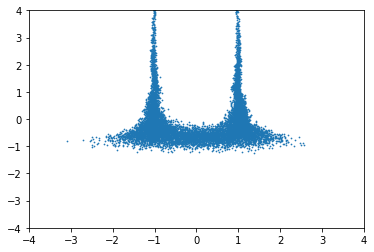

In [34]:
# Versuch gleichung (4) aus dem MAF paper anzuwenden. sollte in der forward methode
# von MADE schon implementiert sein. Plot sollte normalverteilt aussehen (Figure 1 (c))
#TODO gleicher Abstand der Werte auf den Achsen, damit nicht verzerrt.
#print(best_model(train_tensor))
u = torch.t(best_model(train_tensor)[0].detach())
plt.scatter(u[0],u[1],s=0.5)
plt.xlim(-4,4)
plt.ylim(-4,4)


(-4, 4)

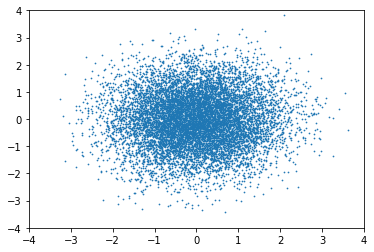

In [35]:
#scatterplot of 2-dim standard normal random numbers for comparison. 
#TODO schöner nebeneinander, gleicher Abstand der Werte auf den Achsen, damit nicht verzerrt.
x = np.ndarray.transpose(np.random.multivariate_normal([0,0],[[1,0],[0,1]],size = 10000))
plt.scatter(x[0],x[1],s = 0.5)
plt.xlim(-4,4)
plt.ylim(-4,4)

(-10, 10)

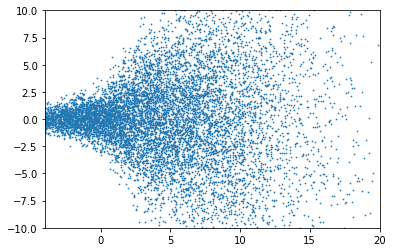

In [36]:
#sample der gelernten Verteilung. TODO: Dichte schätzen und contour plot

x = torch.t(best_model.sample(num_samples = 10000).detach())
plt.scatter(x[0],x[1],s=0.5)
plt.xlim(-4,20)
plt.ylim(-10,10) 

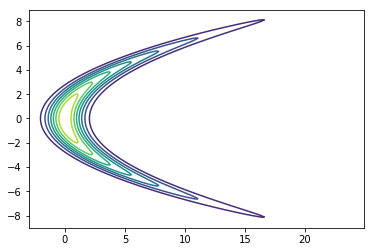

In [11]:
#plot of target density

x1 = np.arange(-3,25,0.1)
x2 = np.arange(-9,9,0.1)

X1, X2 = np.meshgrid(x1,x2)
Y = targetdensity(X1,X2)
plt.contour(X1,X2,Y)